# 1. Data Preparation

## Dataset Download

In [ ]:
%sh
wget http://media.sundog-soft.com/hadoop/ml-100k/u.data -O /tmp/u.data
wget http://media.sundog-soft.com/hadoop/ml-100k/u.item -O /tmp/u.item
wget http://media.sundog-soft.com/hadoop/ml-100k/u.user -O /tmp/u.user

## Upload to HDFS

In [ ]:
%sh
hadoop fs -rm -r -f /tmp/ml-100k
hadoop fs -mkdir /tmp/ml-100k
hadoop fs -put /tmp/u.data /tmp/ml-100k/
hadoop fs -put /tmp/u.item /tmp/ml-100k/
hadoop fs -put /tmp/u.user /tmp/ml-100k/

## Load Raw Files into RDDs

In [ ]:
%pyspark
user_rdd = sc.textFile("/tmp/ml-100k/u.user")
ratings_rdd = sc.textFile("/tmp/ml-100k/u.data")
item_rdd = sc.textFile("/tmp/ml-100k/u.item")

## Parse u.user and Create DataFrame

In [ ]:
%pyspark
from pyspark.sql import Row
# Split and convert to Row objects
user_rows = user_rdd.map(lambda line: line.split('|')) \
                    .map(lambda fields: Row(
                        user_id=int(fields[0]),
                        age=int(fields[1]),
                        gender=fields[2],
                        occupation=fields[3],
                        zip_code=fields[4]
                    ))

#  Create a DataFrame and register a temporary table
user_df = spark.createDataFrame(user_rows)
user_df.createOrReplaceTempView("users")
user_df.show(5)

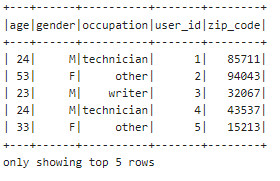

In [22]:
from IPython.display import Image
Image('image/user.png', width =300)

## Parse u.data and Create Ratings DataFrame

In [ ]:
%pyspark
ratings_rows = ratings_rdd.map(lambda line: line.split('\t')) \
                          .map(lambda fields: Row(
                              user_id=int(fields[0]),
                              movie_id=int(fields[1]),
                              rating=int(fields[2]),
                              timestamp=int(fields[3])
                          ))


ratings_df = spark.createDataFrame(ratings_rows)
ratings_df.createOrReplaceTempView("ratings")

ratings_df.show(5)

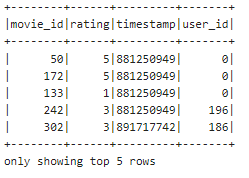

In [21]:
Image('image/rating.png', width =300)

## Parse u.item and Create Movies DataFrame

In [ ]:
%pyspark
item_rows = item_rdd.map(lambda line: line.split('|')) \
                    .map(lambda fields: Row(
                        movie_id=int(fields[0]),
                        title=fields[1],
                        release_date=fields[2],
                        video_release=fields[3],
                        imdb_url=fields[4],
                        genre_flags=fields[5:]
                    ))


item_df = spark.createDataFrame(item_rows)
item_df.createOrReplaceTempView("movies")  

item_df.show(5)

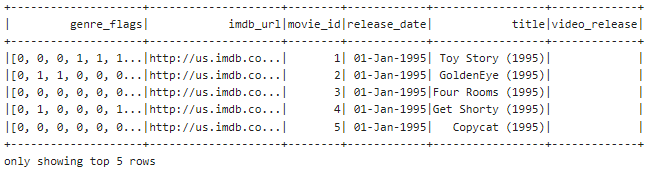

In [25]:
Image('image/item.png', width =700)

# 2. User-Movie Analysis Tasks

## i) Calculate the average rating for each movie

In [ ]:
%sql
SELECT movie_id, AVG(rating) AS avg_rating
FROM ratings
GROUP BY movie_id
LIMIT 10

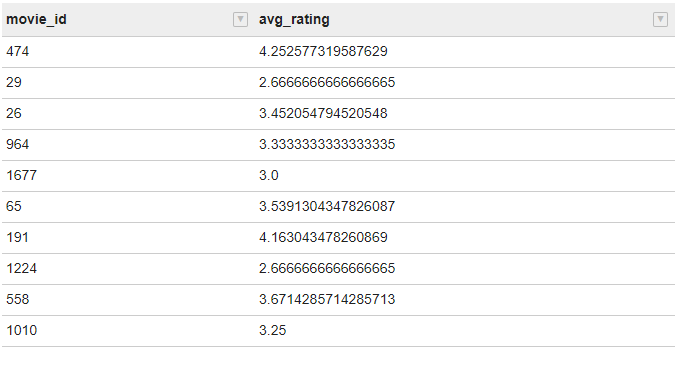

In [26]:
Image('image/Q1.png', width =600)

## ii) Identify the top ten movies with the highest average ratings

In [ ]:
%sql
SELECT m.title, AVG(r.rating) AS avg_rating
FROM ratings r
JOIN movies m ON r.movie_id = m.movie_id
GROUP BY m.title
ORDER BY avg_rating DESC
LIMIT 10

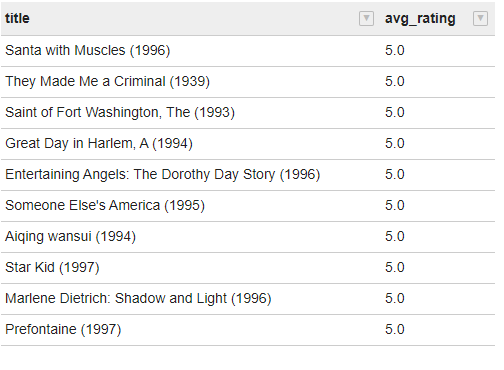

In [27]:
Image('image/Q2.png', width =500)

## iii) Find the users who have rated at least 50 movies and identify their favourite movie genres

In [ ]:
%sql
WITH active_users AS (
    SELECT user_id
    FROM ratings
    GROUP BY user_id
    HAVING COUNT(*) >= 50
),
user_favs AS (
    SELECT r.user_id, m.title, COUNT(*) AS rating_count
    FROM ratings r
    JOIN active_users a ON r.user_id = a.user_id
    JOIN movies m ON r.movie_id = m.movie_id
    GROUP BY r.user_id, m.title
)
SELECT user_id, title AS favorite_movie
FROM (
    SELECT user_id, title, rating_count,
           ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY rating_count DESC) AS rn
    FROM user_favs
) t
WHERE rn = 1
LIMIT 10

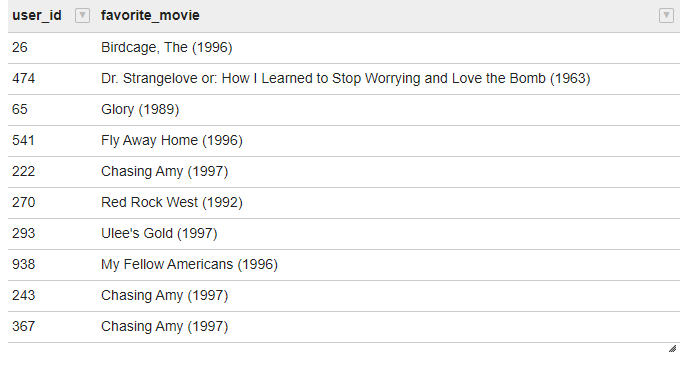

In [28]:
Image('image/Q3.png', width =600)

## iv) Find all the users who are less than 20 years old

In [ ]:
%sql
SELECT * FROM users
WHERE age < 20
LIMIT 10

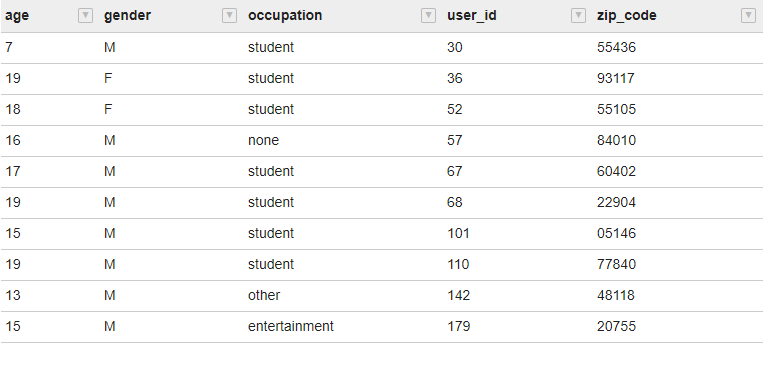

In [29]:
Image('image/Q4.png', width =600)

## v) Find all the users whose occupation is “scientist” and whose age is between 30 and 40 years old

In [ ]:
%sql
SELECT * FROM users
WHERE occupation = 'scientist' AND age BETWEEN 30 AND 40
LIMIT 10

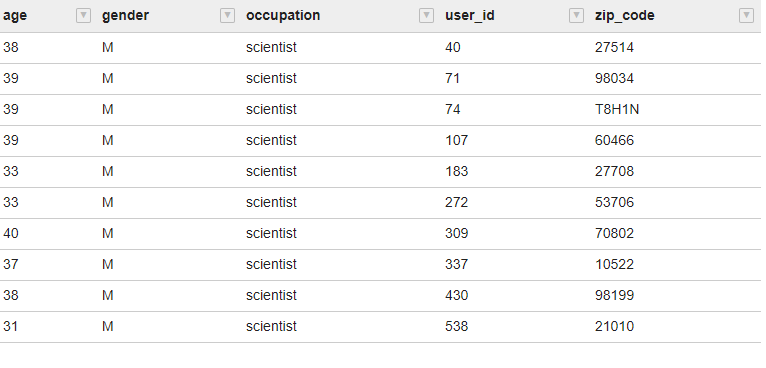

In [30]:
Image('image/Q5.png', width =700)